In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [11]:
from rxrmask.backends import reflectivity
from rxrmask.core import Atom, Structure, FormFactorLocalDB
from rxrmask.core import create_compound
from rxrmask.utils import plot_reflectivity, plot_density_profile

In [7]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False)

la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)

In [8]:
comp_SrTiO3 = create_compound(
    id="SrTiO3",
    name="SrTiO3",
    thickness=50.0,
    density=5.12,
    roughness=0.0,
    formula="Sr:1,Ti:1,O:3",
    atoms_prov=[sr_atom, ti_atom, o_atom],
)
comp_LaMnO3 = create_compound(
    id="LaMnO3",
    name="LaMnO3",
    thickness=50.0,
    density=6.52,
    formula="La:1,Mn:1,O:3",
    atoms_prov=[la_atom, mn_atom, o_atom],
    roughness=2.0,
)
comp_CCO = create_compound(
    id="CCO",
    name="CCO",
    thickness=10.0,
    density=5,
    formula="C:2,O:1",
    atoms_prov=[c_atom, o_atom],
    roughness=2.0,
)

struc = Structure(name=f"Test Structure", n_compounds=3)
struc.add_compound(0, comp_SrTiO3)
struc.add_compound(1, comp_LaMnO3)
struc.add_compound(2, comp_CCO)
struc.create_layers(step=1)

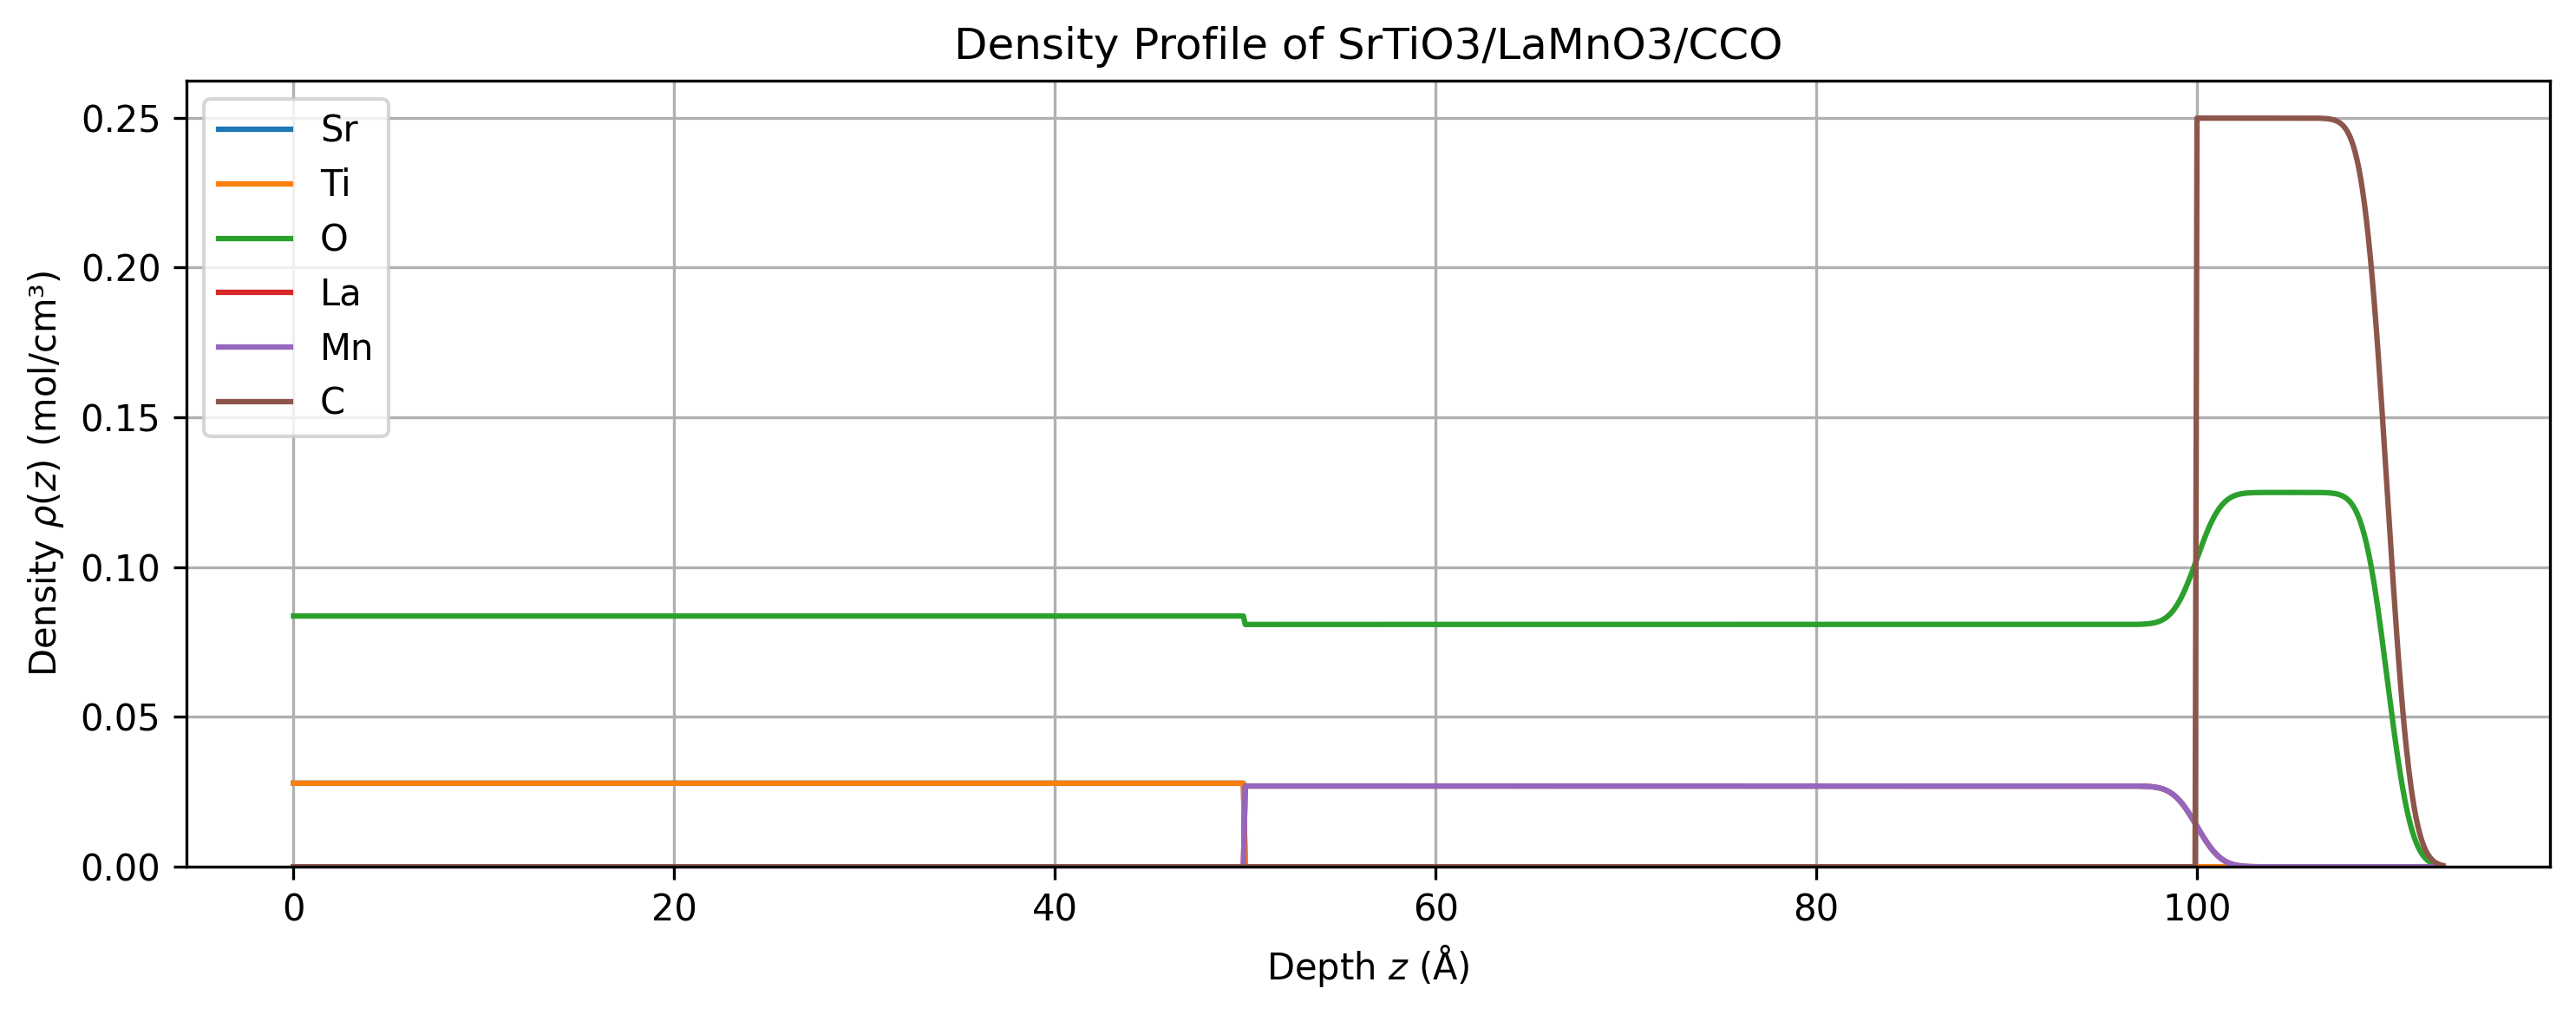

In [13]:
z, dens, m_dens, atoms = struc.get_density_profile(step=0.1)
plot_density_profile(z, dens, title="Density Profile of SrTiO3/LaMnO3/CCO")

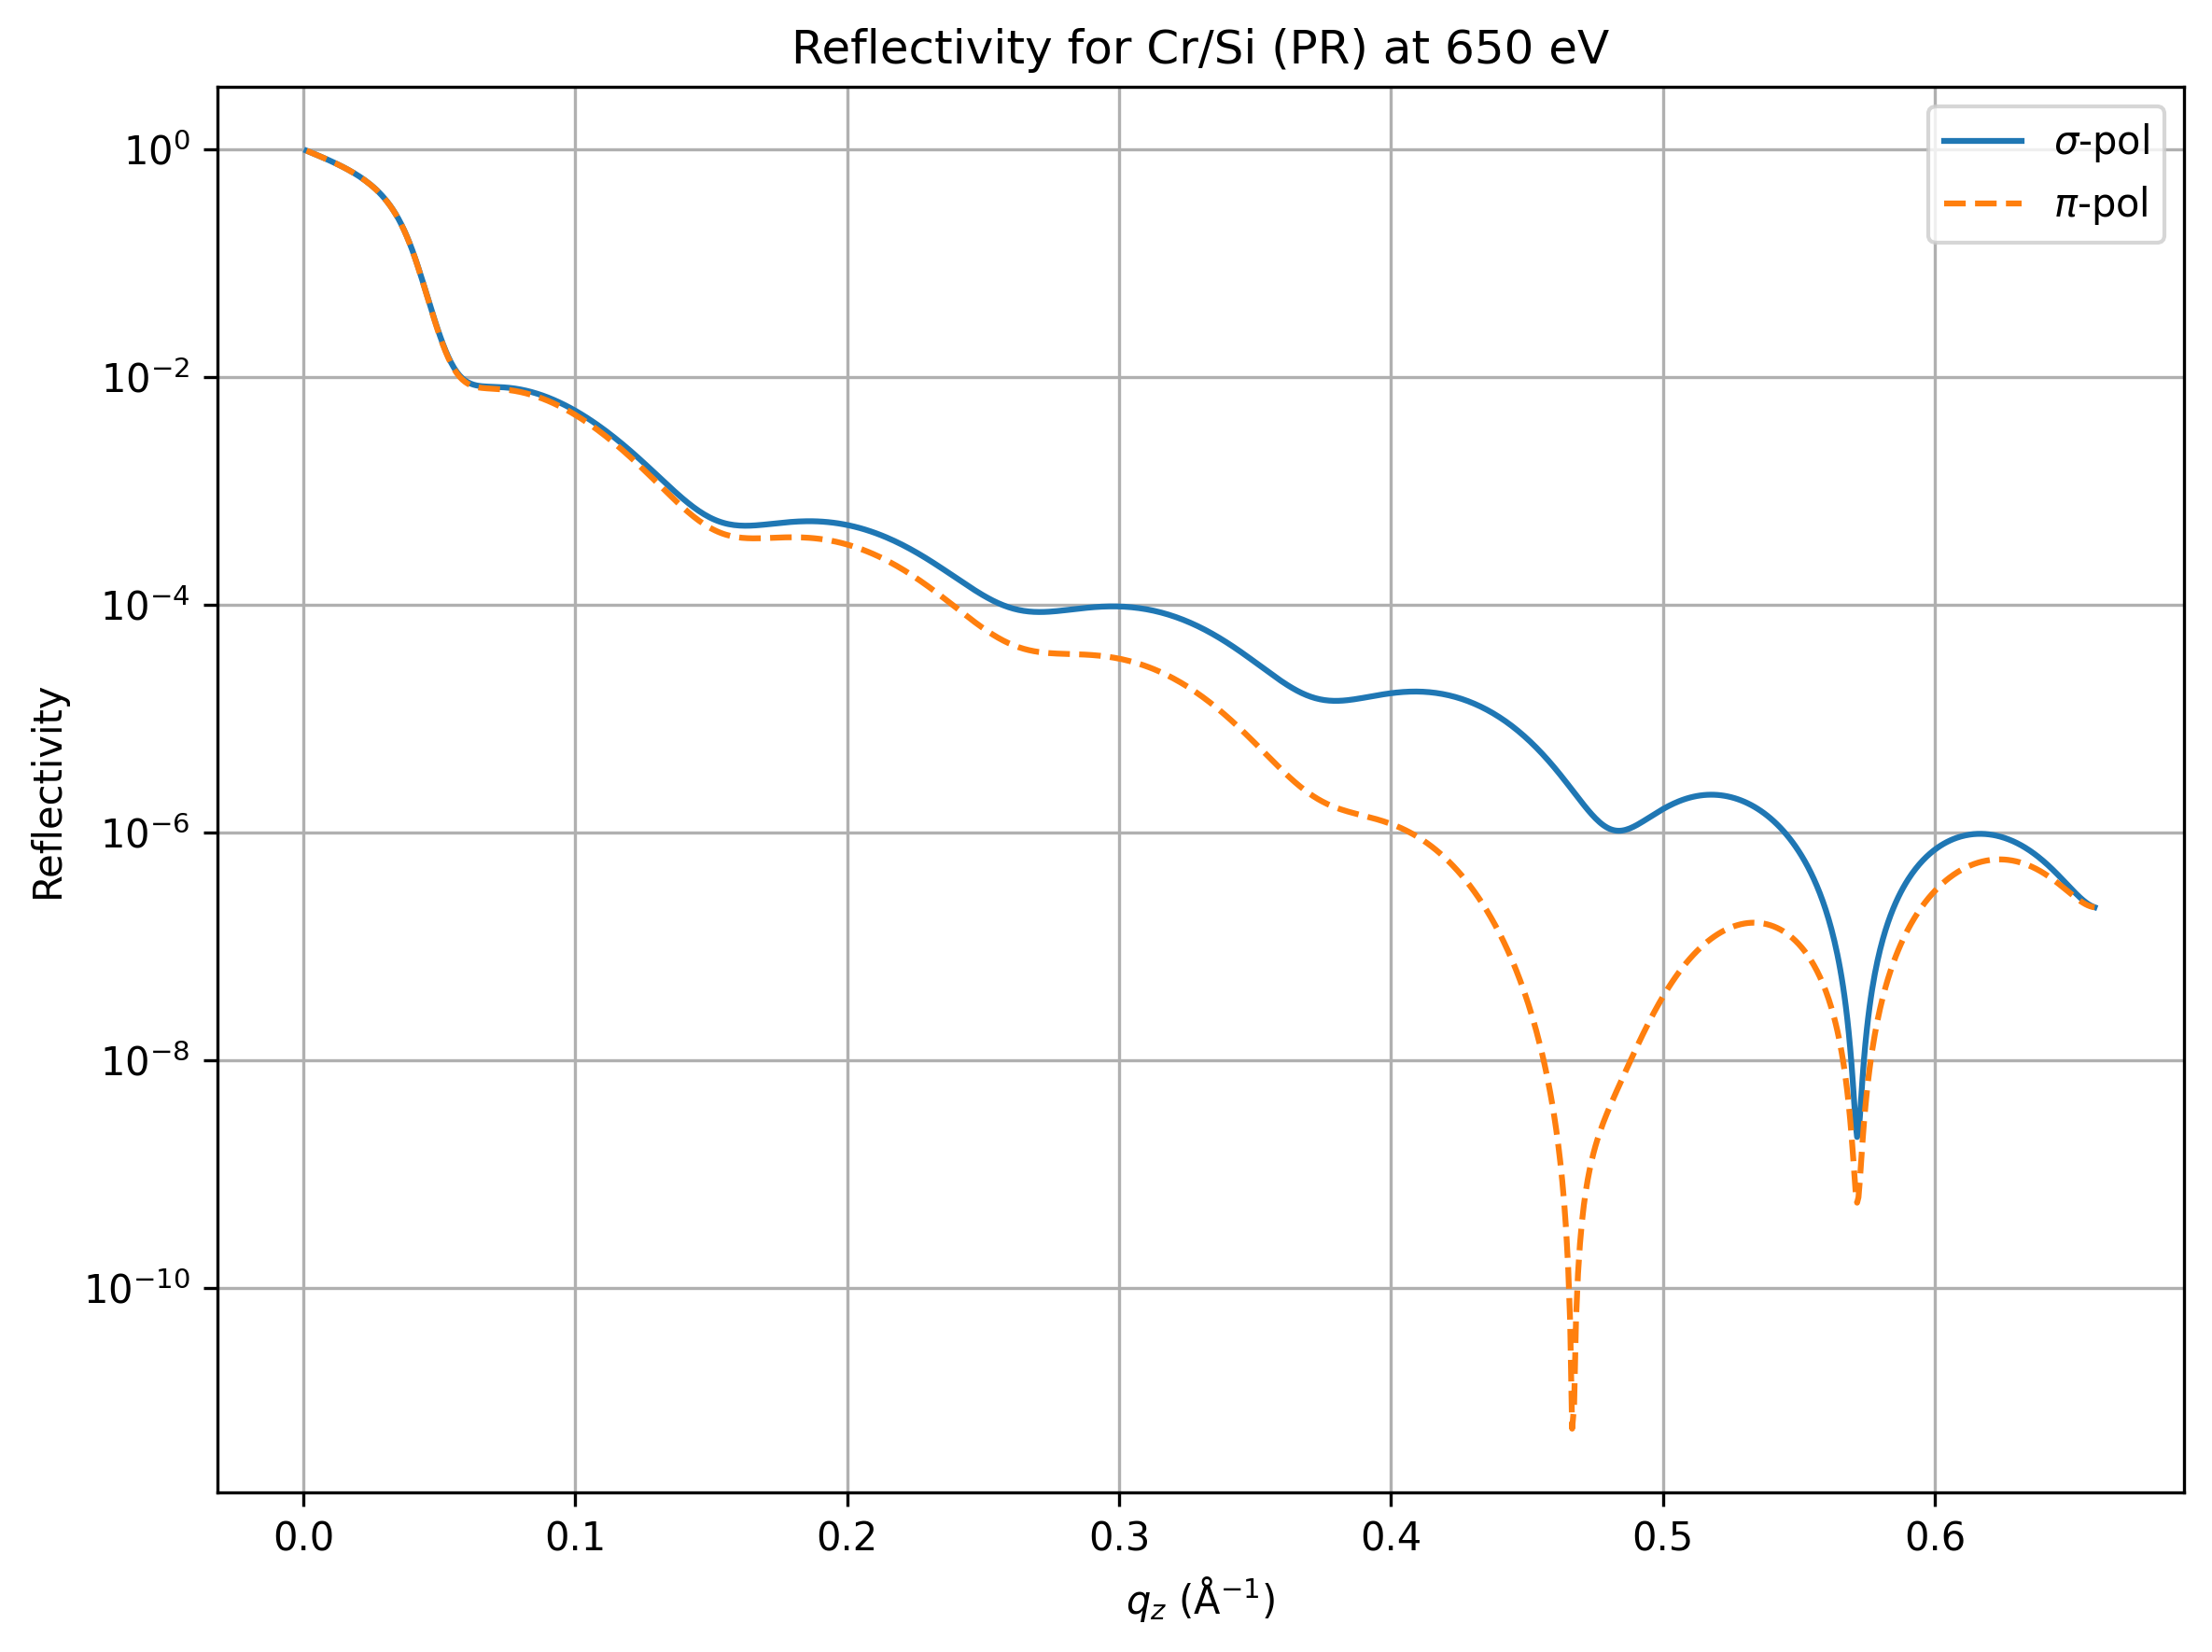

In [10]:
E_eV = 650
Theta = np.linspace(0.1, 89.1, num=1000)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

qz_pr, R_phi_pr, R_pi_pr  = reflectivity(struc, qz, E_eV)
plot_reflectivity(qz_pr, R_phi_pr, R_pi_pr, E_eV, "Cr/Si (PR)")